In [1]:
#Parte B
#Importamos las librerias necesarias
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# Detectar dispositivo (CPU o GPU) # Para utilizar la GPU si está disponible, de lo contrario, usar la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

# Definimos una transformación para convertir las imágenes a tensores y normalizar los valores de los píxeles
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización con media 0.5 y desviación estándar 0.5
])

### Carga del dataset MNIST
# Descarga y carga de los datos de entrenamiento y prueba
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Usando el dispositivo: cuda


In [3]:
## Configuración A
# - Batch size: 64
# - Capas convolucionales: 2
# - Filtros: 32 y 64
# - Kernel: 3x3
# - Pooling: 2x2
# - Capas conectadas: 2
# - Neuronas en capa oculta: 128
# - Tasa de aprendizaje: 0.01
# - Épocas: 5

class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # Primera capa convolucional con 32 filtros de 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # Segunda capa convolucional con 64 filtros de 3x3
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Capa de pooling con reducción 2x2
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Capa completamente conectada con 128 neuronas
        self.fc2 = nn.Linear(128, 10)  # Capa de salida con 10 neuronas (una por cada dígito)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Aplicamos convolución, ReLU y luego MaxPooling
        x = self.pool(F.relu(self.conv2(x)))
        #print(f"Forma después de convoluciones: {x.shape}")  # Depuración
        x = x.view(-1, 64 * 5 * 5)  # Aplanamos la matriz de características
        x = F.relu(self.fc1(x))  # Primera capa conectada con función de activación ReLU
        x = self.fc2(x)  # Capa de salida sin activación porque usamos CrossEntropyLoss
        return x

In [4]:
## Configuración B
# - Batch size: 64
# - Capas convolucionales: 2
# - Filtros: 16, 32
# - Kernel: 5x5
# - Pooling: 2x2
# - Capas conectadas: 3
# - Neuronas en capas ocultas: 256 y 128
# - Tasa de aprendizaje: 0.001
# - Épocas: 7

class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Ajuste dinámico del tamaño
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [5]:
### Definición de la Función de Pérdida y Optimizador
# Usamos CrossEntropyLoss y SGD para ambas configuraciones
netA = NetA().to(device)
netB = NetB().to(device)

criterion = nn.CrossEntropyLoss()
optimizerA = optim.SGD(netA.parameters(), lr=0.01, momentum=0.9)
optimizerB = optim.SGD(netB.parameters(), lr=0.001, momentum=0.9)

In [6]:
### Entrenamiento de las redes
# Implementaremos la función de entrenamiento para ambas configuraciones

def train_model(net, optimizer, epochs, trainloader):
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)  # Mover datos a GPU
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Entrenamos ambas redes


print("Entrenando Red A en", device)
train_model(netA, optimizerA, 5, trainloader)
print("Entrenando Red B en", device)
train_model(netB, optimizerB, 7, trainloader)

Entrenando Red A en cuda
Epoch 1, Loss: 0.2388832120052072
Epoch 2, Loss: 0.057991880008569564
Epoch 3, Loss: 0.04007739840653231
Epoch 4, Loss: 0.030672359534279645
Epoch 5, Loss: 0.024561778717851295
Entrenando Red B en cuda
Epoch 1, Loss: 1.4953734555891327
Epoch 2, Loss: 0.2536180881517274
Epoch 3, Loss: 0.13986190951772845
Epoch 4, Loss: 0.10242959965211051
Epoch 5, Loss: 0.08366065358878104
Epoch 6, Loss: 0.0731227705979954
Epoch 7, Loss: 0.06496036454324307


In [7]:
### Evaluación del modelo
# Función para calcular el accuracy total y por clase

def evaluate_model(net, testloader):
    net.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(len(labels)):
                class_correct[labels[i]] += (predicted[i] == labels[i]).item()
                class_total[labels[i]] += 1
    accuracy = 100 * correct / total
    print(f'Accuracy total: {accuracy}%')
    for i in range(10):
        print(f'Accuracy de la clase {i}: {100 * class_correct[i] / class_total[i]}%')
    return accuracy

# Evaluamos ambas redes
accuracy_A = evaluate_model(netA, testloader)
accuracy_B = evaluate_model(netB, testloader)

Accuracy total: 98.85%
Accuracy de la clase 0: 99.59183673469387%
Accuracy de la clase 1: 99.8237885462555%
Accuracy de la clase 2: 99.51550387596899%
Accuracy de la clase 3: 98.41584158415841%
Accuracy de la clase 4: 99.79633401221996%
Accuracy de la clase 5: 99.43946188340807%
Accuracy de la clase 6: 98.64300626304802%
Accuracy de la clase 7: 99.22178988326849%
Accuracy de la clase 8: 98.76796714579055%
Accuracy de la clase 9: 95.24281466798811%
Accuracy total: 98.15%
Accuracy de la clase 0: 99.38775510204081%
Accuracy de la clase 1: 99.38325991189427%
Accuracy de la clase 2: 98.83720930232558%
Accuracy de la clase 3: 98.91089108910892%
Accuracy de la clase 4: 98.06517311608961%
Accuracy de la clase 5: 97.53363228699551%
Accuracy de la clase 6: 98.01670146137788%
Accuracy de la clase 7: 97.08171206225681%
Accuracy de la clase 8: 98.04928131416838%
Accuracy de la clase 9: 96.0356788899901%


Aun que la red B sea algo mas compleja y tuvo mas epoch de entrenamiento es sutilmente peor que la A, al ser mas compleja internamente habria que haberla dejado durante mas epochs, tambien podria ser que tiene un lr de 0.001 mientras que la A es de 0.01 esto tambien ha podido afectar al aprendizaje mas lento
tampoco tiene mucho sentido seguir entrenando la B para ver si mejora su resultado si la red A ya funciona algo mejor siendo mas simple

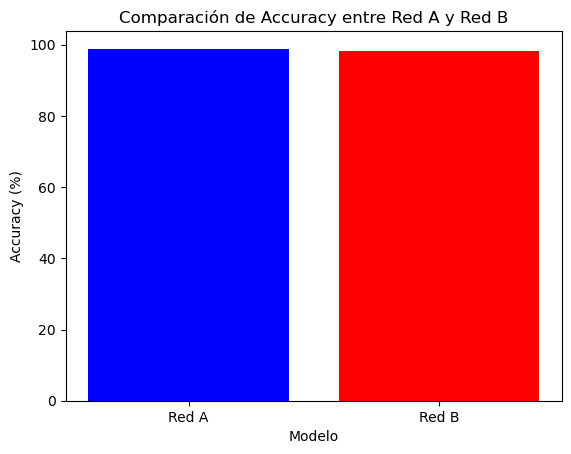

In [8]:
# Gráfica de barras para comparar resultados

labels = ['Red A', 'Red B']
accuracies = [accuracy_A, accuracy_B]
plt.bar(labels, accuracies, color=['blue', 'red'])
plt.xlabel('Modelo')
plt.ylabel('Accuracy (%)')
plt.title('Comparación de Accuracy entre Red A y Red B')
plt.show()

(La grafica no es muy significativa ya que tienen valores muy similares y no se ve diferencia alguna)

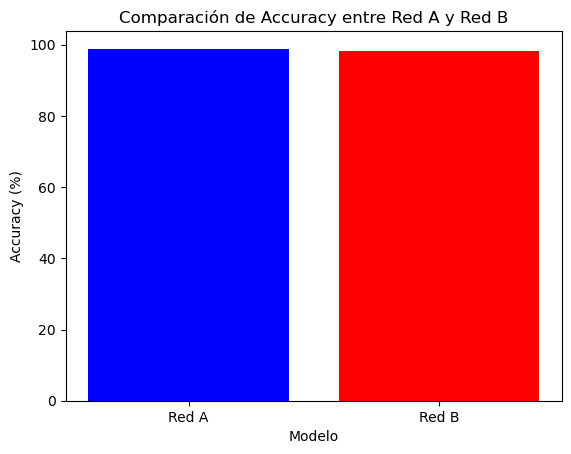

In [9]:
# Gráfica de barras para comparar resultados
labels = ['Red A', 'Red B']
accuracies = [accuracy_A, accuracy_B]
plt.bar(labels, accuracies, color=['blue', 'red'])
plt.xlabel('Modelo')
plt.ylabel('Accuracy (%)')
plt.title('Comparación de Accuracy entre Red A y Red B')
plt.show()

PREGUNTAS:

1-El batch size define cuántos ejemplos de entrenamiento se procesan antes de actualizar los pesos del modelo.

Si batch_size = 4, significa que en cada iteración, la red toma 4 imágenes, calcula su pérdida y ajusta los pesos en función de ese pequeño grupo.

En una epoch, el modelo pasa por todos los datos dividiéndolos en lotes de 4.

Con un batch pequeño, hay actualizaciones más frecuentes de los pesos, lo que puede hacer que el entrenamiento sea más ruidoso pero permita salir de mínimos locales.

Con un batch grande, hay menos ruido pero el entrenamiento puede ser más lento y requerir más memoria.

En general, batch_size = 4 es pequeño y puede hacer que el entrenamiento sea más inestable, pero también más dinámico.

2-En entrenamiento (shuffle=True)

Se mezclan los datos en cada epoch para evitar que la red aprenda patrones específicos del orden de los datos.

Ayuda a generalizar mejor y evita sesgos en el aprendizaje.

En test (shuffle=False)

No se mezclan los datos para mantener la misma distribución y evaluar correctamente el modelo.

Así, se comparan los resultados de manera consistente.

En resumen, se barajan en entrenamiento para mejorar la generalización y no en test para una evaluación estable.

3-a. Explicación del constructor y configuración de capas
La clase Net define la arquitectura de la CNN en PyTorch. Supongamos que tiene esta estructura:

super(NetA, self).__init__(): 
Llama al constructor de la clase base nn.Module. Es necesario para que PyTorch pueda inicializar correctamente la clase como un módulo de red neuronal


self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # Primera capa convolucional con 32 filtros de 3x3
1: Número de canales de entrada (en este caso, la imagen es en escala de grises, por lo que tiene 1 canal)
32: Número de filtros o kernels que aplicará esta capa. Esto significa que esta capa extraerá 32 características diferentes
kernel_size=3: Tamaño del filtro (3x3), lo que significa que cada filtro es de 3 píxeles por 3 píxeles

self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Capa de pooling con reducción 2x2
kernel_size=2: Tamaño de la ventana de pooling (2x2)
stride=2: Desplazamiento de la ventana de pooling. Esto significa que la ventana se moverá 2 píxeles a la vez. La capa reduce las dimensiones de la imagen a la mitad

self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Capa completamente conectada con 128 neuronas
Crea una capa completamente conectada (fully connected)
64 * 5 * 5: Número de entradas a la capa (la salida de la última capa convolucional tiene dimensiones de 64 x 5 x 5 después de las operaciones de convolución y pooling)
128: Número de neuronas en esta capa, es decir, cuántas salidas tendrá esta capa.

self.fc2 = nn.Linear(128, 10)  # Capa de salida con 10 neuronas (una por cada dígito)
(igual q la anteior, entran las 128 de antes y salen las 10 clases distintas)



3-b.

def forward(self, x)
Define la propagación hacia adelante de los datos a través de la red. La entrada x es un tensor de imágenes

x = self.pool(F.relu(self.conv1(x)))
self.conv1(x): Aplica la primera capa convolucional a la entrada x
F.relu(self.conv1(x)): Aplica la función de activación ReLU a la salida de la convolución para introducir no linealidad.
self.pool(F.relu(self.conv1(x))): Aplica max pooling para reducir las dimensiones espaciales de la salida de la ReLU.

x = self.pool(F.relu(self.conv2(x)))
(lo mismo pero para la segunda capa)

x.view(-1, 64 * 5 * 5):
Aplana las salidas de las capas convolucionales y de pooling en un vector unidimensional para que pueda ser procesado por las capas completamente conectadas. El -1 permite que PyTorch calcule automáticamente el tamaño adecuado de la dimensión restante.

return x: Devuelve la salida final, que contiene las probabilidades de cada clase para cada imagen


El forward propagation es el proceso en el que los datos de entrada pasan a través de las capas de la red neuronal para obtener una predicción


4.

loss.backward()  # Calcula los gradientes de la pérdida con respecto a los pesos
En la funcion def train_model(net, optimizer, epochs, trainloader):


optimizer.step()  # Actualiza los pesos de la red
Recalcula los pesos de la red
En la funcion def train_model(net, optimizer, epochs, trainloader):


Antes de poder calcular los gradientes y actualizar los pesos hay que:
1. Definir la función de pérdida
    criterion = nn.CrossEntropyLoss()
2. Obtener los outputs
    outputs = net(images)  # Predicción de la red
3. Calcular la pérdida
    loss = criterion(outputs, labels)  # Pérdida entre la predicción y las etiquetas reales

Una vez realizados estos pasos el cálculo de los gradientes y la actualización de los pesos pueden realizarse
con loss.backward() y optimizer.step()



5.

Este seria un ejemplo del output 
tensor([-2.3, 1.2, 0.5, -0.8, 3.1, -1.2, 0.7, 2.4, -0.6, 1.8])
cada número representa un logit para una clase, entonces para obtener la predicción final,
se aplica torch.max(outputs, 1), que devuelve el índice de la clase con el mayor logit para saber cual ha sido la predicción real




